In [1]:
from venture import shortcuts
import venture.lite.types as t
import venture.lite.value as v

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import codecs
import matplotlib.pyplot as plt
%matplotlib inline  
figlength = 10
figheigth = 10

In [3]:
ripl = shortcuts.make_lite_ripl()

Couldn't import dot_parser, loading of dot files will not be possible.


# Create Training Data

generate n data points

In [4]:
n = 100

data generating function

In [5]:
def f(x):
    return 0.3 + 0.4*x + 0.5*np.sin(2.7*x) + (1.1/(1+x**2))

generate data

In [6]:
training_x = np.random.normal(0,1,n)
training_y =np.zeros(training_x.shape)
for i in range(n):
    if np.random.uniform()>0.10:
        training_y[i] = f(training_x[i]) + np.random.normal(0,0.1,1)
    else:
        training_y[i] = f(training_x[i]) + np.random.normal(0,1,1)

helper points to plot the the actual function (below, blue line)

In [7]:
x2plot = np.linspace(-3,3,1000)
f2plot = f(x2plot)

### Util-functions

# The Venture Program

In [8]:
program = """
// / SETTING UP THE MODEL
assume alpha_sf = tag ( "hyperhyper" , 0 , gamma( 7 , 1 ));
assume beta_sf = tag ( "hyperhyper" , 1 , gamma( 7 , 1 ));
assume alpha_l = tag ( "hyperhyper" , 2 , gamma( 7 , 1 ));
assume beta_l = tag ( "hyperhyper" , 3 , gamma( 7 , 1 ));


// Parameters of the covariance function
assume noise_sigma = tag ( "hyper" , 0 , gamma( 1 , 1 ));

assume length_scale = tag ( "hyper" , 1 , gamma( alpha_l , beta_l ));
assume scale_factor = tag ( "hyper" , 2 , gamma( alpha_sf , beta_sf ));




assume se = gp_cov_scale(scale_factor, gp_cov_se(length_scale));
assume wn = gp_cov_scale(noise_sigma, gp_cov_delta(0.00001));

assume zero = gp_mean_const(0);

// a restricted data acquisition function
assume gp = make_gp(zero, gp_cov_sum(se,gp_cov_const(1.)));


assume obs_func = proc(x){student_t(4,lookup(gp(array(x)),0),0.1)};
"""
ripl.execute_program(program);

# Sample from the Prior

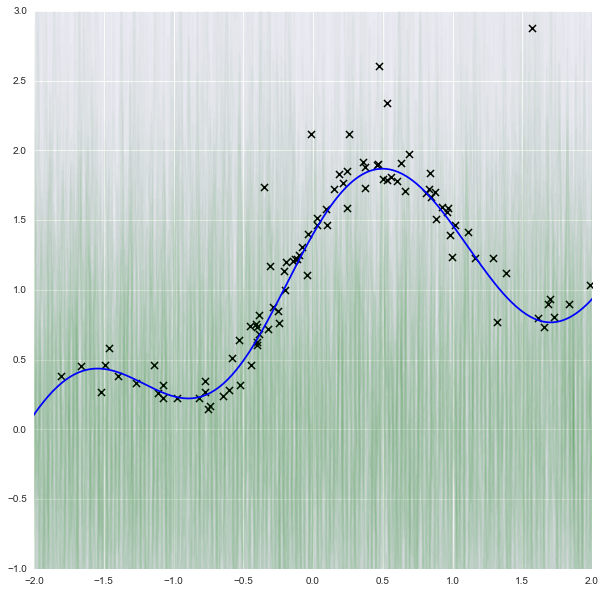

In [9]:
fig = plt.figure(figsize=(figlength,figheigth), dpi=200)
prior_length_scale = []
prior_scale_factor = []
prior_noise_sigma = []
#xpost= np.random.uniform(-3,3,200)
for i in range(100):
    ripl.infer("reset_to_prior")
    prior_noise_sigma.append(ripl.sample("noise_sigma")) 
    prior_length_scale.append(ripl.sample("length_scale"))
    prior_scale_factor.append(ripl.sample("scale_factor"))
    xs= np.linspace(-3,3,200)
    ys = []
    for x in xs:
        ys.append(ripl.sample("obs_func(%d)" % (x,)))
        
  
    plt.plot(xs, ys,c="green",alpha=0.01,linewidth=2)

plt.axis((-2,2,-1,3))
plt.plot(x2plot,f2plot,color='blue')
plt.scatter(training_x,training_y,color='black',marker='x',s=50,edgecolor='black',linewidth='1.5')

# Make Observations

In [10]:
for i in range(len(training_x)):
    ripl.observe("obs_func(%d)" % (training_x[i],),training_y[i])

Inference does not work

In [11]:
ripl.infer("""mh(default, one, 100)""")

[2.2]

## What we need to get to run 

In [ ]:
#ripl.infer("grad_ascent(default, all, 0.05, 100, 1)")

## What we probably need to get to work for reasonable inference 

In [ ]:
#ripl.infer("hmc(default, all, 0.05, 100, 1))
# slice sampling?

# Samples from Posterior

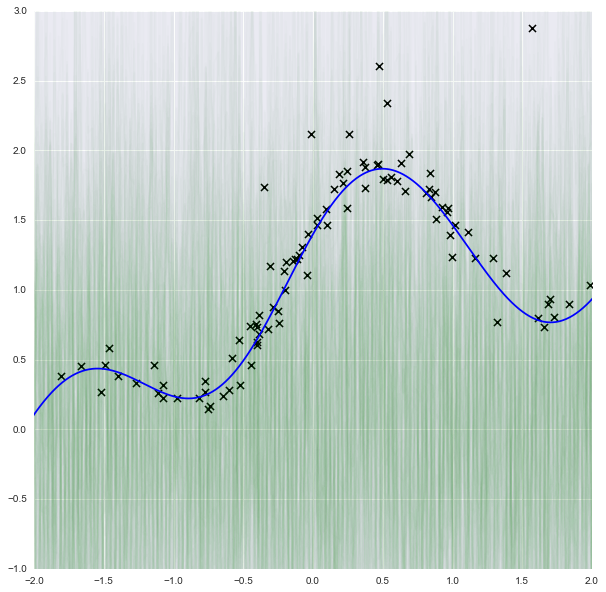

In [12]:
fig = plt.figure(figsize=(figlength,figheigth), dpi=200)
posterior_length_scale = []
posterior_scale_factor = []
posterior_noise_sigma = []
#xpost= np.random.uniform(-3,3,200)
for i in range(100):
    ripl.infer("""mh("hyperhyper", all, 2)""")
    ripl.infer("""mh("hyper", 0, 1)""")
    posterior_noise_sigma.append(ripl.sample("noise_sigma"))
    ripl.infer("""mh("hyper", 1, 1)""")
    posterior_length_scale.append(ripl.sample("length_scale"))
    ripl.infer("""mh("hyper", 2, 1)""")
    posterior_scale_factor.append(ripl.sample("scale_factor"))
    #ripl.infer("""mh(default, one, 10)""")
    xs= np.linspace(-3,3,200)
    ys = []
    for x in xs:
        ys.append(ripl.sample("obs_func(%d)" % (x,)))
        
  
    plt.plot(xs, ys,c="green",alpha=0.01,linewidth=2)

plt.axis((-2,2,-1,3))
plt.plot(x2plot,f2plot,color='blue')
plt.scatter(training_x,training_y,color='black',marker='x',s=50,edgecolor='black',linewidth='1.5')

# Shift of Hyperprior to Hyperposterior

### Hyperprior

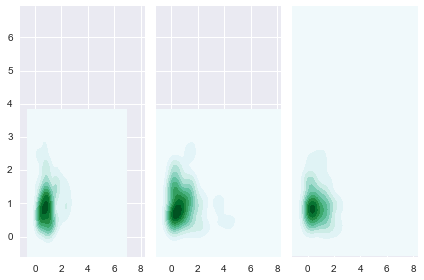

In [13]:
f, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(prior_length_scale), np.array(prior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_length_scale), shade=True, ax=axes[2])
f.tight_layout()

### Hyperposterior

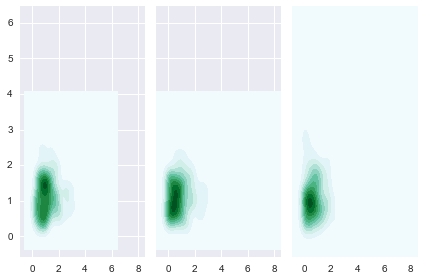

In [14]:
f, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(posterior_length_scale), np.array(posterior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_length_scale), shade=True, ax=axes[2])
f.tight_layout()